# Feature extraction from GAERS calcium recordings



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
import graphviz 

Load the data and cut off start and end, because the laser was turned on/off there.

In [2]:
validators = pd.read_csv("../../Data/Validators/2016-10-13T1513.dat",
                   sep="\t", header=None, names=['start', 'end']);
                         
raw = pd.read_csv("../../Data/Raw/2016-10-13T1513.dat",
                   sep="\t", header=None, names=['yvalue']);
                  
start_second = 275
end_second = 1810
freq = 2000 # abtastrate
start_value = start_second*freq
end_value = end_second*freq
window = 1000 # half second window for classification
# skip everything before laser turned on and after laser turned off

# prepare data
raw = raw[start_value:end_value] 

Add an additional colum 'group', because we calculate the features for every half of a second and add a y-value for the validators.

In [3]:
raw['group'] = raw.index // window
validators['start'] = validators['start'] // window 
validators['end'] = validators['end'] // window 

validators['yvalue'] = 0.0

Calculate the features for every half second.

In [4]:
group = raw.groupby('group')
data_mean =  group.mean()
data_var = group.var()*10000
#data_linelength = None
# todo manhattan length
data_max = group.max()
data_min = group.min()

data = pd.concat([data_mean, data_var, data_max, data_min], axis=1)
data.columns = ['mean', 'var', 'max', 'min']
data['group'] = data.index

Add column if there is a seizure in the half second (from the validators) and add an additional column if there was a seizure one half second before.

In [5]:
data['seizure'] = 0

for index, row in validators.iterrows():
    start = row['start'].astype(np.int64)
    end = row['end'].astype(np.int64)
    #todo check if
    data.seizure[(data['group'] >= start) & (data['group'] <= end)] = 1

data['seiz_bef'] = data.seizure.shift(fill_value=0)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


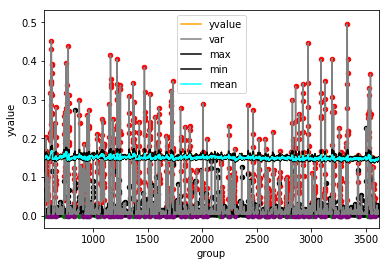

In [6]:
seizure=data[data.seizure==1]
normal=data[data.seizure==0]
raw['tmp'] = raw.index / window

ax = seizure.plot(kind='scatter', x='group', y='var', color='red')
ax = raw.plot(x='tmp', y='yvalue',color='orange', ax=ax)
ax = normal.plot(kind='scatter', x='group', y='var', color='black', ax=ax)
ax = data.plot(x='group', y='var', color='grey', ax=ax)
#colors = np.where(data.seizure == 1, 'red', 'black')
#ax = data.plot(y='var', c=colors)
ax = validators.plot(kind='scatter', x='start', y='yvalue', color='green', ax=ax)
ax = validators.plot(kind='scatter', x='end', y='yvalue', color='purple', ax=ax)
ax = data.plot(y='max', ax=ax, color='black')
ax = data.plot(y='min', ax=ax, color='black')
ax = data.plot(y='mean', ax=ax, color='cyan')

![subrangeplot](generalplot_subrange.png)

## Decision tree without 'seiz_bef'

Decision tree without "seiz_bef" acc.: 0.9413680781758957
Feature importance
[('mean', 0.012865281790940182), ('var', 0.98713471820906), ('max', 0.0), ('min', 0.0)]


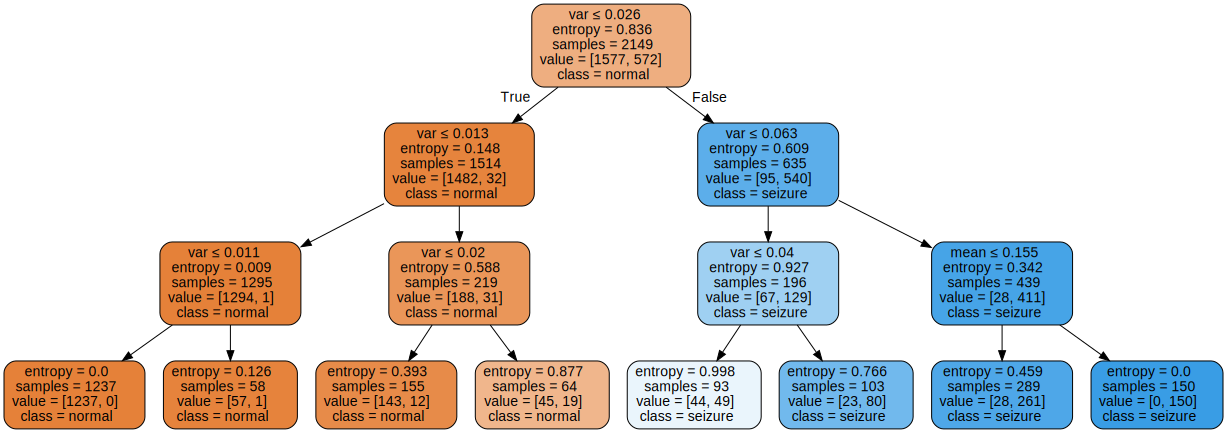

In [7]:
features = ['mean', 'var', 'max', 'min']#, 'seiz_bef']
X =  data[features]
Y = data['seizure']

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 0.3, random_state = 42)

clf1 = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=10, max_depth=3, random_state=42)
clf1 = clf1.fit(X_train,Y_train)

Y_pred = clf1.predict(X_test)

accuracy = accuracy_score(Y_test,Y_pred)
print('Decision tree without "seiz_bef" acc.:',accuracy)
importances = list(zip(features, clf1.feature_importances_))
print('Feature importance')
print(importances)

dot_data = tree.export_graphviz(clf1, out_file=None,   
                      filled=True, rounded=True,
                      feature_names=features,
                      class_names=['normal', 'seizure'],
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## Decision tree with 'seiz_bef'

Decision tree with "seiz_bef" acc.: 0.9609120521172638
Feature importance
[('mean', 0.0), ('var', 0.16465899167613463), ('max', 0.014861157523722825), ('min', 0.0), ('seiz_bef', 0.8204798508001425)]


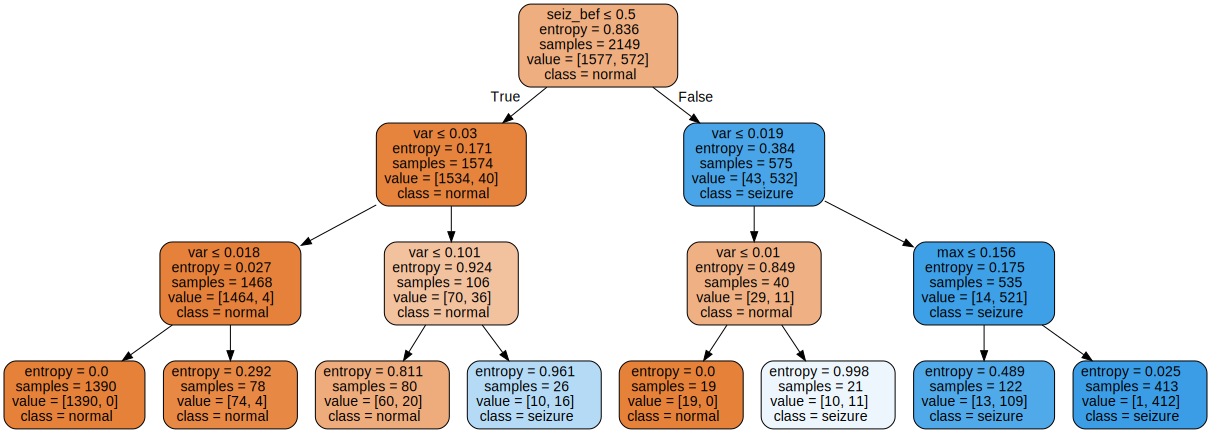

In [8]:
features = ['mean', 'var', 'max', 'min', 'seiz_bef']
X =  data[features]
Y = data['seizure']

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 0.3, random_state = 42)

clf2 = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=10, max_depth=3, random_state=42)
clf2 = clf2.fit(X_train,Y_train)

Y_pred = clf2.predict(X_test)

accuracy = accuracy_score(Y_test,Y_pred)

print('Decision tree with "seiz_bef" acc.:',accuracy)
importances = list(zip(features, clf2.feature_importances_))
print('Feature importance')
print(importances)

dot_data = tree.export_graphviz(clf2, out_file=None,   
                      filled=True, rounded=True,
                      feature_names=features,
                      class_names=['normal', 'seizure'],
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## Random Forest

In [9]:
clf3 = ensemble.RandomForestClassifier(max_depth=3, n_estimators=100, min_samples_leaf=10, random_state=42)
clf3 = clf3.fit(X_train,Y_train)
Y_pred = clf3.predict(X_test)
accuracy = accuracy_score(Y_test,Y_pred)

print('RandomForest acc.:',accuracy)
importances = list(zip(features, clf3.feature_importances_))
print('Feature importance')
print(importances)

RandomForest acc.: 0.9587404994571118
Feature importance
[('mean', 0.038253624932292), ('var', 0.29890454764822805), ('max', 0.15614111012980025), ('min', 0.0054677467622796065), ('seiz_bef', 0.5012329705273999)]


## SVM

In [10]:
clf4 = svm.SVC(gamma='scale')
clf4 = clf4.fit(X_train, Y_train)
Y_pred = clf4.predict(X_test)

accuracy = accuracy_score(Y_test,Y_pred)

print('SVM acc.:',accuracy)

SVM acc.: 0.9467969598262758
